In [1]:
from pandas import Series, DataFrame
import numpy as np
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Reading in Data

In [35]:
df = pd.read_csv('birthrate_new.csv')

In [ ]:
#df.columns

In [ ]:
#df['NUMBER_OF_CHILDREN'].unique()

In [18]:
df.shape

(763296, 20)

# Feature Engineering (X)

In [36]:
# 1 = have married before, 0 = have never married
df['ever_married'] = (df['MARITAL_STATUS'] != 'Never married or under 15 years old').astype(int)

# convert the number of times married into numbers
marriage_map = {'N/A (age less than 15 years; never married)': 0,
                'One time': 1,
                'Two times': 2,
                'Three or more times': 3}
df['num_times_married'] = df['NUM_TIMES_MARRIED'].map(marriage_map)

# calculate years since marriage
df['years_since_marriage'] = 2023 - pd.to_numeric(df['YEAR_LAST_MARRIED'], errors='coerce')
df['years_since_marriage'] = df['years_since_marriage'].fillna(0)

# 1 = moved somewhere last year, 0 = didn't move anywhere
df['moved_last_year'] = df['MOBILITY_STATUS'].apply(lambda x: 0 if x=='Yes, same house (nonmovers)' else 1)

# calculate number of years of education
education_map = {
    'No schooling completed': 0, 'Nursery school, preschool': 0, 'Kindergarten': 0,
    'Grade 1': 1, 'Grade 2': 2, 'Grade 3': 3, 'Grade 4': 4, 'Grade 5': 5, 'Grade 6': 6, 'Grade 7': 7, 'Grade 8': 8, 'Grade 9': 9, 'Grade 10': 10,
    'Grade 11': 11, '12th grade - no diploma': 12, 'Regular high school diploma': 12, 'GED or alternative credential': 12,
    'Some college, but less than 1 year': 13, '1 or more years of college credit, no degree': 14,
    "Associate's degree": 15, "Bachelor's degree": 16, "Master's degree": 18, "Professional degree beyond a bachelor's degree": 19, "Doctorate degree": 20 }
df['education_years'] = df['EDUCATION'].map(education_map)

# 1 = has medical insurance, 0 = no medical insurance
df['has_insurance'] = (df['HEALTH_INSURANCE'] == 'With health insurance coverage').astype(int)

# 1 = employed of some forms, 0 = not employed
employed_group = ['Civilian employed, at work', 'Civilian employed, with a job but not at work', 'Armed forces, at work', 'Armed forces, with a job but not at work' ]
df['employed'] = df['EMPLOYMENT_STATUS'].apply(lambda x: 1 if x in employed_group else 0)

# 1 = give birth for the past year, 0 = no birth past year
df['gave_birth_12mo'] = df['GAVE_BIRTH_12MO'].map(lambda x: 1 if x == 'Yes' else 0)

# convert Region into dummy variables
df = pd.get_dummies(df, columns=['REGION'], drop_first=False)

# Create Target Variable (y = above_2child)

In [37]:
df['above_2child'] = df['NUMBER_OF_CHILDREN'].map(
    lambda x: 0 if x in ['0 children present', '1 child present'] else 1)

In [15]:
df['above_2child'].value_counts(normalize=True)   #30% of the data have over 2 children

above_2child
0    0.705435
1    0.294565
Name: proportion, dtype: float64

In [38]:
df.columns

Index(['YEAR', 'HOUSEHOLD_INCOME', 'CHILDREN_STATUS', 'NUMBER_OF_CHILDREN',
       'PERSON_WEIGHT', 'AGE', 'CLASS_OF_WORKER', 'GAVE_BIRTH_12MO',
       'MARITAL_STATUS', 'NUM_TIMES_MARRIED', 'YEAR_LAST_MARRIED',
       'MOBILITY_STATUS', 'GRADE_LEVEL_ATTENDING', 'EDUCATION', 'SEX',
       'WHEN_LAST_WORKED', 'EMPLOYMENT_STATUS', 'HEALTH_INSURANCE',
       'INCOME_TOTAL', 'ever_married', 'num_times_married',
       'years_since_marriage', 'moved_last_year', 'education_years',
       'has_insurance', 'employed', 'gave_birth_12mo', 'REGION_Midwest',
       'REGION_Northeast', 'REGION_South', 'REGION_West', 'above_2child'],
      dtype='object')

# Logistic Regression

In [27]:
formula = 'above_2child ~ 0 + PERSON_WEIGHT + AGE + ever_married + num_times_married + years_since_marriage' + \
          ' + moved_last_year + education_years + has_insurance + employed + HOUSEHOLD_INCOME + gave_birth_12mo'

In [ ]:
#formula = (
    #'above_2child ~ 0 + PERSON_WEIGHT + AGE + ever_married + num_times_married + years_since_marriage'
    #' + moved_last_year + education_years + has_insurance + employed + HOUSEHOLD_INCOME + gave_birth_12mo'
    #' + REGION_Northeast + REGION_South + REGION_West + REGION_Midwest')
#if use this formula has to run this in model step: X.columns = X.columns.str.replace(r"[\[\]<>\:]", "_", regex=True)

In [16]:
Y, X = dmatrices(formula, df, return_type='dataframe')
y = Y['above_2child'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

model = LogisticRegression(max_iter=10000)
result = model.fit(X_train, y_train)

prediction_train = model.predict(X_train)
print("Train Accuracy:", metrics.accuracy_score(y_train, prediction_train))

prediction = model.predict(X_test)
print("Test Accuracy:", metrics.accuracy_score(y_test, prediction))

Train Accuracy: 0.7088078576548689
Test Accuracy: 0.7091650690644529


In [ ]:
weights = Series(model.coef_[0],
                 index=X.columns.values)
weights.sort_values(ascending=False)

# XGBoost Classifier --> better test accuracy

In [32]:
Y, X = dmatrices(formula, df, return_type='dataframe')
y = Y['above_2child'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

xgb_model = XGBClassifier(n_estimators=200,
                          learning_rate=0.05,
                          max_depth=4)
xgb_model.fit(X_train, y_train)

train_preds = xgb_model.predict(X_train)
test_preds = xgb_model.predict(X_test)
print("Train Accuracy:", accuracy_score(y_train, train_preds))
print("Test Accuracy:", accuracy_score(y_test, test_preds))

#feature importance
importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns,
                              'Importance': importances}).sort_values(by='Importance', ascending=False)
print(importance_df)

Train Accuracy: 0.7830030300931862
Test Accuracy: 0.7816052299455433
                 Feature  Importance
4   years_since_marriage    0.431374
1                    AGE    0.181359
10       gave_birth_12mo    0.092096
6        education_years    0.063897
2           ever_married    0.056669
8               employed    0.050655
5        moved_last_year    0.048431
3      num_times_married    0.035131
9       HOUSEHOLD_INCOME    0.030229
0          PERSON_WEIGHT    0.007025
7          has_insurance    0.003133


# Model Evaluation (XGBoost)

In [ ]:
confusion_matrix(y_test, test_preds)

In [ ]:
np.round(confusion_matrix(y_test, test_preds) / np.sum(confusion_matrix(y_test, test_preds)),2)

# Cross-Validation to find optimal n_estimators & max_depth

### n_estimators = 200, max_depth = 4

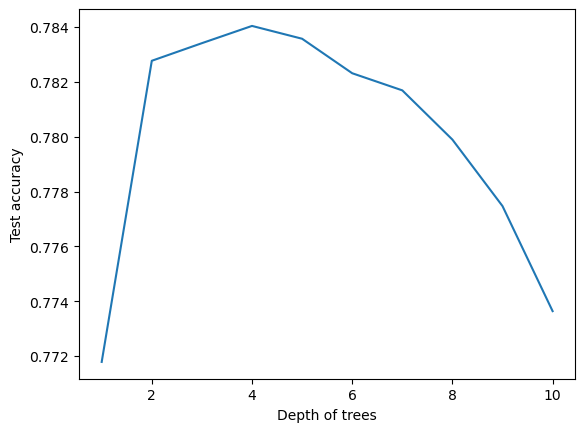

In [13]:
scores = {}
for depth in range(1, 11):
    model = XGBClassifier(n_estimators=200,
                          max_depth=depth,
                          random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[depth] = accuracy_test
Series(scores).sort_index().plot()
plt.xlabel('Depth of trees')
plt.ylabel('Test accuracy')
#plt.savefig('tree depth.png', dpi=300, bbox_inches='tight')  # save as PNG

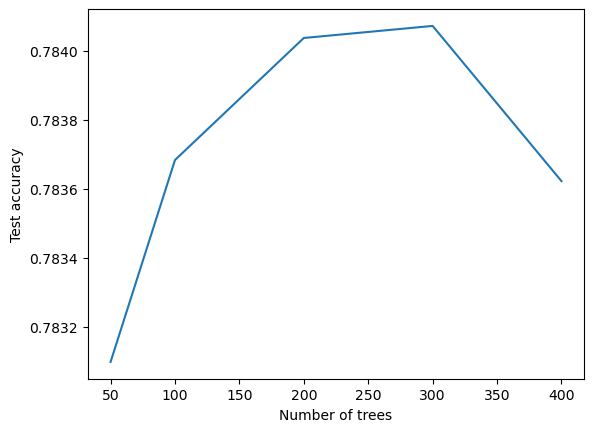

In [14]:
scores = {}
for num_trees in [50, 100, 200, 300, 400]:
    model = XGBClassifier(n_estimators=num_trees,
                          max_depth=4,
                          random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[num_trees] = accuracy_test
Series(scores).sort_index().plot()
plt.xlabel('Number of trees')
plt.ylabel('Test accuracy')
#plt.savefig('numtree.png', dpi=300, bbox_inches='tight')  # save as PNG

# Visualizations

In [ ]:
df1 = df.copy()
edu_avg_actual = df1.groupby('education_years')['above_2child'].mean().reset_index()

plt.figure(figsize=(6, 4))
plt.plot(edu_avg_actual['education_years'], edu_avg_actual['above_2child'], color='red', linewidth=2)
plt.xlabel('Years of Education')
plt.ylabel('Probability of ≥ 2 Children')
plt.title('Probability of ≥ 2 Children by Education')
plt.grid(True)
plt.legend()

In [ ]:
df1 = df.copy()
mapping = {
    '0 children present': 0,
    '1 child present': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9+': 9}
df1['nchild'] = df1['NUMBER_OF_CHILDREN'].map(mapping)

age_avg_children = df1.groupby('education_years')['nchild'].mean().reset_index()

plt.figure(figsize=(7,4))
plt.plot(age_avg_children['education_years'], age_avg_children['nchild'], label='Avg Number of Children')
plt.axhline(y=2.1, color='red', linestyle='--', linewidth=2, label='Replacement Threshold (2.1)')
plt.xlabel('Years of Education')
plt.ylabel('Average Number of Children')
plt.title('Average Number of Children by Years of Education')
plt.legend()

In [ ]:
df1 = df.copy()
mapping = {
    '0 children present': 0,
    '1 child present': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9+': 9}
df1['nchild'] = df1['NUMBER_OF_CHILDREN'].map(mapping)
age_avg_children = df1.groupby('AGE')['nchild'].mean().reset_index()

plt.figure(figsize=(7,4))
plt.plot(age_avg_children['AGE'], age_avg_children['nchild'], label='Avg Number of Children')
plt.axhline(y=2.1, color='red', linestyle='--', linewidth=2, label='Replacement Threshold (2.1)')
plt.xlabel('Age')
plt.ylabel('Average Number of Children')
plt.title('Average Number of Children by Age')
plt.legend()

In [ ]:
df1.columns

In [ ]:
#Histogram of Number of Children by region (stacked)
plt.figure(figsize=(7,4))
sns.histplot(data=df1, x='nchild', bins=range(0,12), hue='REGION', multiple='stack')
plt.title('Histogram of Number of Children by Region')
plt.xlabel('Number of Children')
plt.ylabel('Count')
plt.show()

In [ ]:
#Average Number of Children by Education Years and Region (Line Plot)
df = pd.read_csv('birthrate_new.csv')
df1 = df.copy()
education_map = {
    'No schooling completed': 0, 'Nursery school, preschool': 0, 'Kindergarten': 0,
    'Grade 1': 1, 'Grade 2': 2, 'Grade 3': 3, 'Grade 4': 4, 'Grade 5': 5, 'Grade 6': 6, 'Grade 7': 7, 'Grade 8': 8, 'Grade 9': 9, 'Grade 10': 10,
    'Grade 11': 11, '12th grade - no diploma': 12, 'Regular high school diploma': 12, 'GED or alternative credential': 12,
    'Some college, but less than 1 year': 13, '1 or more years of college credit, no degree': 14,
    "Associate's degree": 15, "Bachelor's degree": 16, "Master's degree": 18, "Professional degree beyond a bachelor's degree": 19, "Doctorate degree": 20 }
df1['education_years'] = df1['EDUCATION'].map(education_map)
mapping = {
    '0 children present': 0,
    '1 child present': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9+': 9}
df1['nchild'] = df1['NUMBER_OF_CHILDREN'].map(mapping)

avg_children = df1.groupby(['education_years', 'REGION'])['nchild'].mean().reset_index()
plt.figure(figsize=(7,4))
sns.lineplot(data=avg_children, x='education_years', y='nchild', hue='REGION', marker='o')
plt.title('Average Number of Children by Education Years and Region')
plt.xlabel('Years of Education')
plt.ylabel('Average Number of Children')
plt.legend(title='Region')
plt.grid(True)
plt.show()

In [ ]:
#average number of children per region
avg_children_region = df1.groupby('REGION')['nchild'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=avg_children_region, x='REGION', y='nchild', palette='pastel')
plt.title('Average Number of Children by Region')
plt.ylabel('Average Number of Children')
plt.xlabel('Region')
plt.show()


In [ ]:
#Total number of children per region
total_children_region = df1.groupby('REGION')['nchild'].sum().reset_index()
total_children_region = total_children_region.sort_values('nchild', ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=total_children_region, x='nchild', y='REGION', palette='viridis')
plt.title('Total Number of Children by Region')
plt.xlabel('Total Number of Children')
plt.ylabel('Region')
plt.show()

# Coefficient Weights (LG)

In [ ]:
import matplotlib.cm as cm

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs)

# Normalize absolute coefficient values
norm = plt.Normalize(coef_df['Coefficient'].abs().min(),
                     coef_df['Coefficient'].abs().max())

# Colors for bars
colors = cm.Blues(norm(coef_df['Coefficient'].abs()) * 0.7 + 0.3)  

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
ax.set_xlabel("Coefficient Value")
ax.set_title("Feature Influence on Having Above 2 Children")

# Colorbar legend (tied to ax)
sm = plt.cm.ScalarMappable(cmap=cm.Blues, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Coefficient Magnitude")

plt.show()

# Feature Importance Graph (XGBoost)

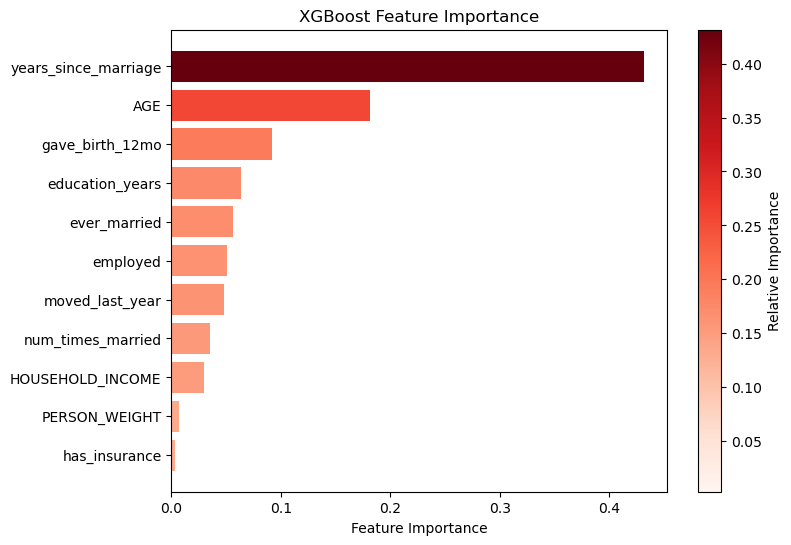

In [33]:
import matplotlib.cm as cm

importances = xgb_model.feature_importances_
feat_names = X.columns
if 'Intercept' in feat_names:
    mask = feat_names != 'Intercept'
    importances = importances[mask]
    feat_names = feat_names[mask]

importance_df = (
    pd.DataFrame({'Feature': feat_names, 'Importance': importances})
      .sort_values('Importance', ascending=True)  # ascending for barh
)

# Color mapping
vals = importance_df['Importance'].values
norm = plt.Normalize(vals.min(), vals.max())
colors = cm.Reds(norm(vals) * 0.7 + 0.3)  # avoid pale pinks

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
ax.set_xlabel("Feature Importance")
ax.set_title("XGBoost Feature Importance")

# Colorbar legend (tied to ax)
sm = plt.cm.ScalarMappable(cmap=cm.Reds, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Relative Importance")

plt.show()